# Coding Project: Picture enhacement

Nowadays image enhacement has become practically common and its methods have become wider and diversified with the encrease of image edditing apps such as instagram, vsco or photoshop.\
The following code contains different methods than can be applied to an image to change one or many of its characters and therefore enhancing it.

### Saturation 

Let's start by a very basic modification that can be applied to an image: equalization. Since we can equalize different parameters in an image by flattening the histogram of that parameter, the $equalize$ function is a method that will equalize any channel either for an RGB or an HSV color representation.\
This function consists on computing a look up table that has the effect of flattening the histogram. In our case we choose to use the cumulative histogram (that has this property) by converting it to a look up table by multiply the histogram by 255 and cast it in a 8-bit integer.  This function takes 3 arguments:
- the image that we want to modify
- the type of the color representation that interests us ('rgb' for RGB or 'hsv' for HSV)
- the channel that we want to equalize (R,G or B ; H,S or V)

The $equalize$ function calls another function which is cumul_hist and that returns the cumulative histogram of a grayscale image.



Let's take the example of a low saturated image and try to equalize its saturation. For this we will use the equalize function with parameters that target the 2rd channel of the HSV color representation:

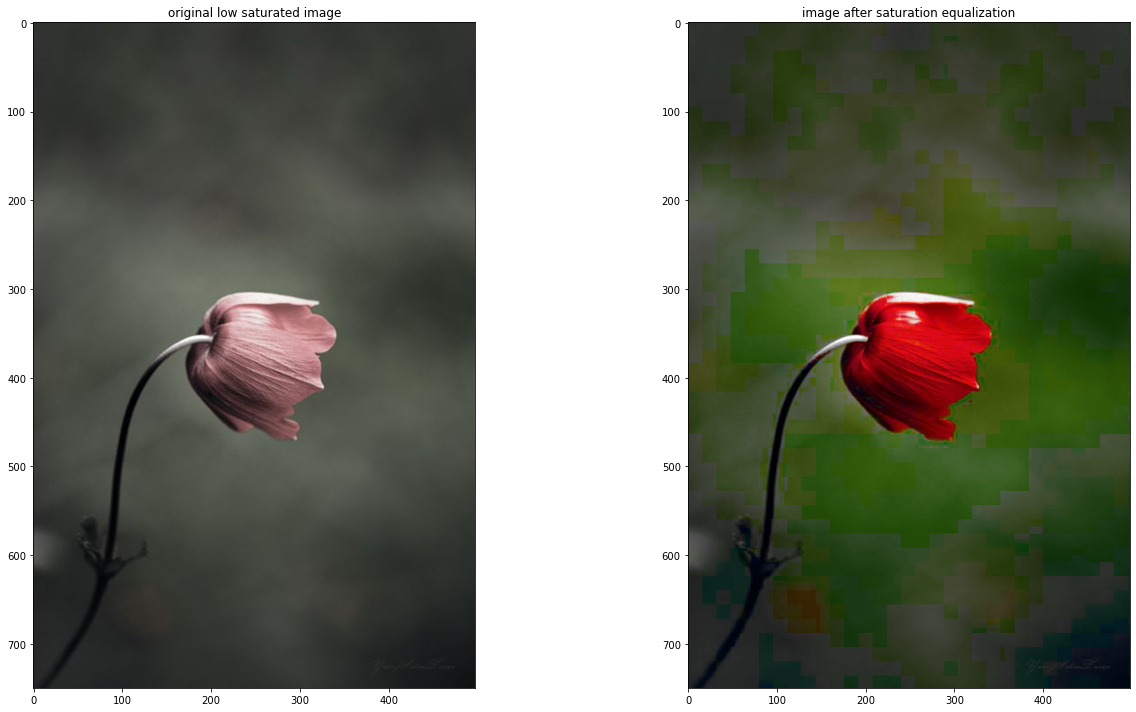

In [361]:
from skimage.io import imread,imshow,imsave
from matplotlib import pyplot as plt
from skimage.color import rgb2hsv,hsv2rgb,rgb2gray
import numpy as np
%matplotlib inline

def cumul_hist(im):
    cumul_hist = np.zeros(256)
    c=0
    for v in range(256):
        c += (im==v).sum()
        cumul_hist[v] = c
    cumul_hist/=cumul_hist.max()
    return cumul_hist

def equalize(im,typ,channel):
    
    if typ=='hsv':
        hsv=rgb2hsv(im)
        c=(hsv[:,:,channel]*255).astype(int)                        #converting the channel from [0 1] to [0 255]
        lut = (cumul_hist(c)*255).astype('uint8')                   #transforming the cumulative hist to a LUT
        hsv[:,:,channel] = lut[c]                                   #applying the LUT to the hsv channel
        hsv[:,:,channel]=(hsv[:,:,channel]/255).astype('float64')   #reconverting back to [0 1]
        im_c=np.uint8(hsv2rgb(hsv)*255)
    
    else:
        im_c=im.copy()
        cumul_h=cumul_hist(im_c[:,:,channel])
        lut = (cumul_h*255).astype('uint8')
        im_c[:,:,channel]=lut[im_c[:,:,channel]]
        
    return im_c 

im_lowsat=imread('lowsat.jpg')
im_highsat=equalize(im_lowsat,'hsv',1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('original low saturated image')
plt.imshow(im_lowsat)
plt.subplot(1,2,2)
plt.title('image after saturation equalization')
plt.imshow(im_highsat)
plt.tight_layout()
plt.show()

### Blur

We can notice that by equalizing the saturation of the image, the background of the image has become pixeled. But no worries, we can rearrange that by blurring the background.\
To do that we will use the gaussian filter that has the effect of blurring the image. The gaussian filter is given by the $gaussian$ method from the $skimage.filters$ library. We will set 3 arguments in this method: the image that we want to blur, a parameter sigma which is the standard deviation for gaussian kernel and a final argument set to True to filter the 3 RGB channels separately.

To blur only the background, we will create a mask and apply the gaussian filter only on the background of the image:

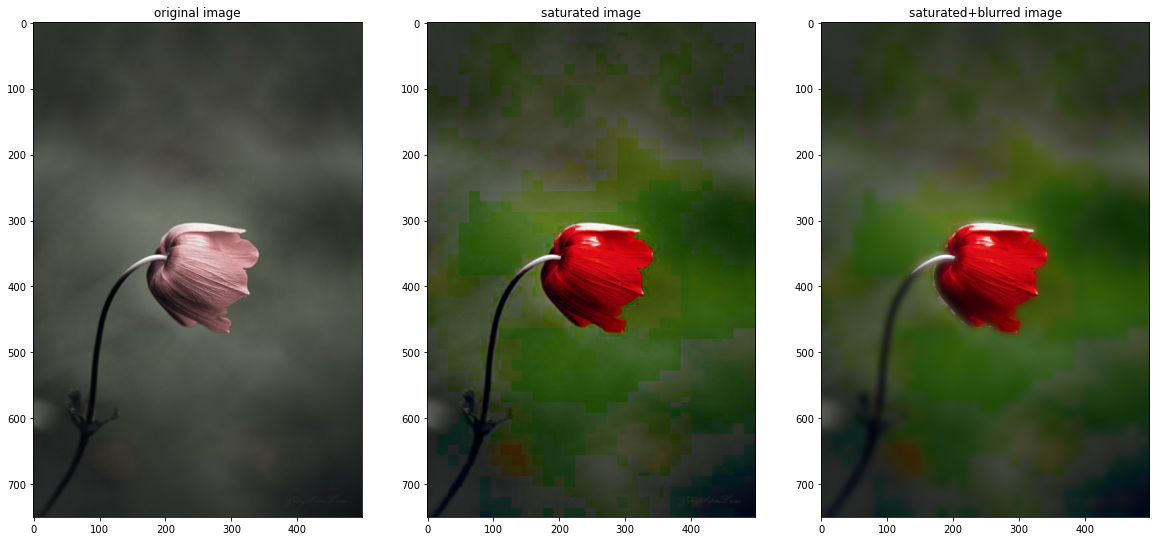

In [398]:
from skimage.filters import gaussian 

bw = im_highsat[:,:,0]>100    #creating a BW image by thresholding 

im_out = gaussian(im_highsat,5,multichannel=True)

im_blur=im_highsat.copy()
for y in range(im_lowsat.shape[0]):
    for x in range(im_lowsat.shape[1]):
        if (bw[y,x]==False):
            for color in range(3):
                im_blur[y,x,color]=im_out[y,x,color]*255

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(im_lowsat)
plt.subplot(1,3,2)
plt.title('saturated image')
plt.imshow(im_highsat)
plt.subplot(1,3,3)
plt.title('saturated+blurred image')
plt.imshow(im_blur)

plt.show()

### Contrast 

Another thing that we can modify in an image is its contrast. We can enhance an image contrast by equalizing each of its RGB channels separately. To do that, we will use the same function as before (equalize function), but this time we will work on the RGB color representation by equalizing its 3 channels respectively:

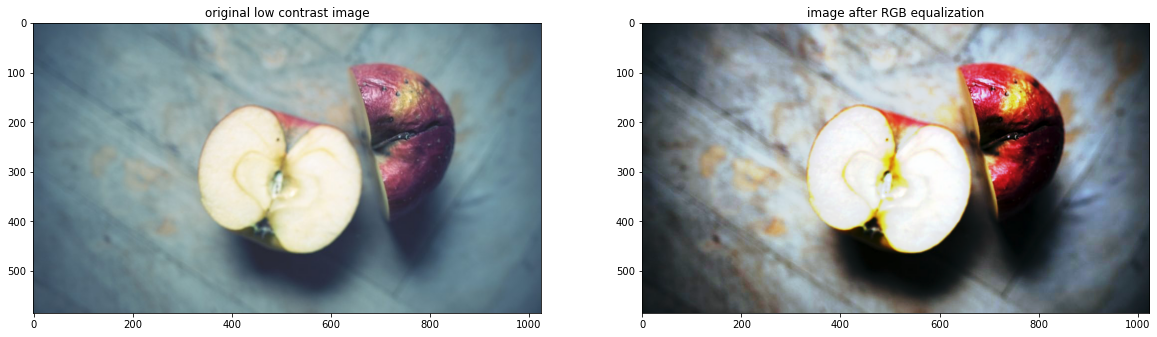

In [362]:
im_lowc=imread('lowcont.jpg')
im_highc=im_lowc.copy()

im1=equalize(im_lowc,'rgb',0)
im2=equalize(im1,'rgb',1)
im3=equalize(im2,'rgb',2)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('original low contrast image')
plt.imshow(im_lowc)
plt.subplot(1,2,2)
plt.title('image after RGB equalization')
plt.imshow(im3)
plt.show()

### Gamma correction

Our eyes do not perceive light the way cameras do. The gamma correction is what translates between the light sensitivity of our eye and that of the camera. This correction transforms the input image pixelwise according to the equation $O = I^{gamma}$ after scaling each pixel to the range 0 to 1. In other words, this correction defines the relationship between a pixel's numerical value and its actual luminance.\
We can directly use the adjust _gamma from the exposure module of the skimage library. This method takes 3 arguments: the image, a float gamma set by default to 1 and a float gain also set by default to 1.
- For gamma greater than 1, the histogram will shift towards left and the output image will be darker than the input image.
- For gamma less than 1, the histogram will shift towards right and the output image will be brighter than the input image.


We can creat a function that determines gamma automatically from the input image brightness: 
- If the image is bright, the gamma value will be greater than 1. 
- If it is dark, the gamma value will be lower than one. 

This function is the auto_gamma function that takes 2 arguments: the input image and the value of gamma set by default to auto but can be changed by the user. The auto_gamma function calls the is_bright function that determines the brightness of the image based on the value of the HSV representation.

Let's use the apple image above and apply the gamma correction to it. We will use the auto_gamma function with 1 input only and we will expect the output image to be darker than the input image (because the imput image is bright):

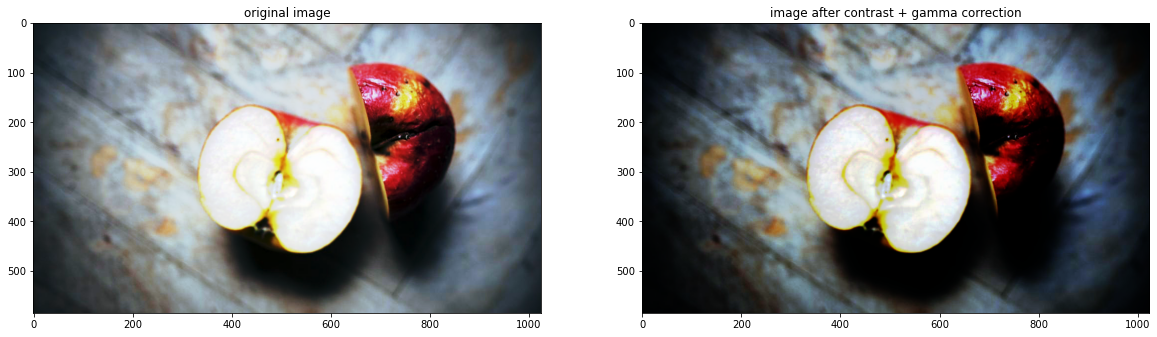

In [387]:
from skimage import exposure

def is_bright(im):
    
    result=1
    hsv= rgb2hsv(im)             #transforms the rgb rebresentation of the image to hsv representation
    d_h = np.abs(hsv[:,:,2])     #we are interested in the Value (luminosity)
    dark_val= (hsv[:,:,2]<0.5).sum()
    bright_val= (hsv[:,:,2]>=0.5).sum()
    
    if(dark_val>bright_val): result=0
        
    return result

def auto_gamma(im,gamma='auto'):
            
    if gamma == 'auto':     
        res=is_bright(im)
        if res==0 : g= 0.5  #output image brighter
        if res==1 : g= 2    #output image darker
    
    else: 
        g = gamma
    
    im_gamma = exposure.adjust_gamma(im,g)
    
    return im_gamma

im_ex=imread('etretat.jpg')    
im_gamma = auto_gamma(im3)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(im3)
plt.subplot(1,2,2)
plt.title('image after contrast + gamma correction')
plt.imshow(im_gamma)
plt.show()

In case we apply this function to the background blurred flower image the input image's brightness will be automatically decreased since the original image is dark:

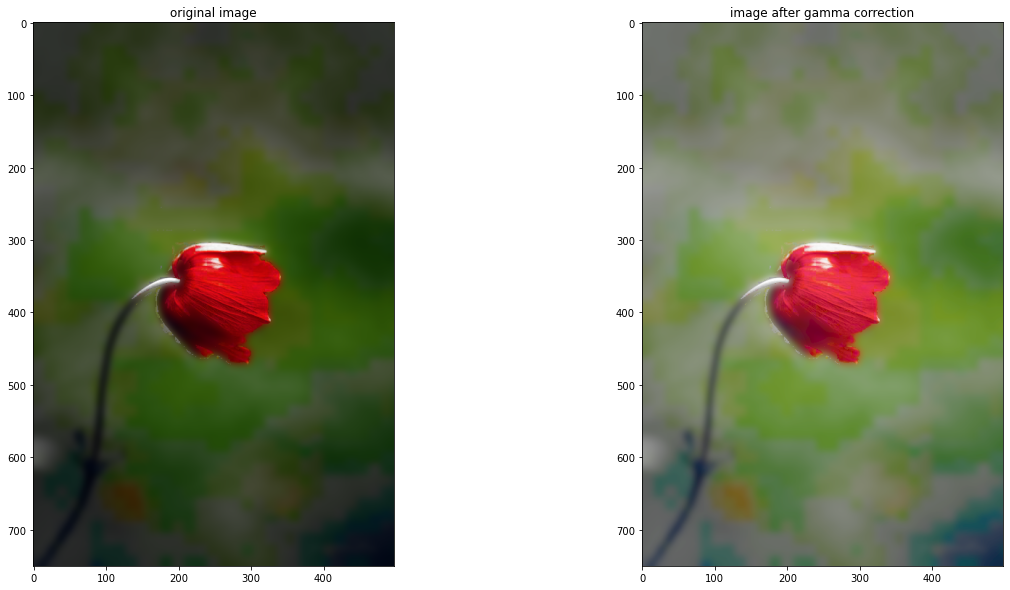

In [383]:
im_gamma2 = auto_gamma(im_blur)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(im_blur)
plt.subplot(1,2,2)
plt.title('image after gamma correction')
plt.imshow(im_gamma2)
plt.show()

### Smoothing

It has also became common for some models to smooth their skin to cover some imperfections. We can recreate the same effect with the following $smooth$ function. This function applies a combination of an opening and a closing operation on the value channel of the HSV representation (we can actually apply it to any channel). The combination of these 2 operations creat a smoothing effect on the image. Since we want to remove the imperfections on the skin only, we will use a mask to apply the smoothing only on the skin. The mask is given by the mask_ method and the $smooth$ function takes 4 arguments:
- the image 
- the power which refers to the intensity of smoothing and which is set by default to 25 but can be modified
- the coordinates of the skin part in the image. These are set by default for this image to (800,400)
- the tolerance of the mask which is also set by default to 0.3 but can be modified 

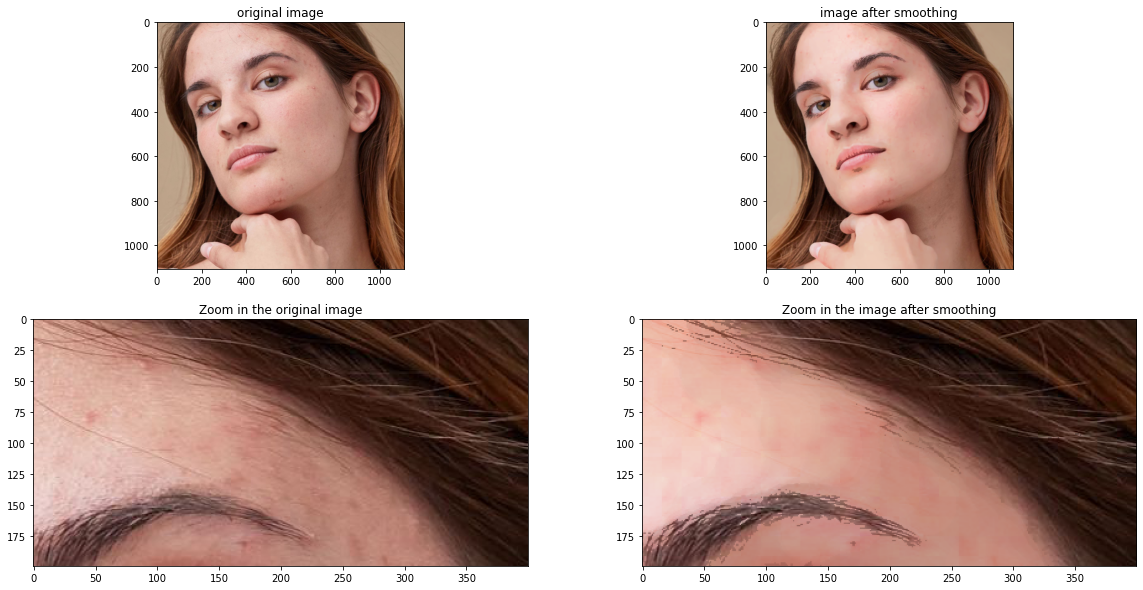

In [399]:
from skimage.morphology import opening,closing,disk

def mask_(im,coords,tol):  
    
    refcolor=im[coords[0],coords[1]]    
    dmap=np.sqrt(((im-refcolor)**2).sum(axis=2))
    dmap/=dmap.max()
    mask=dmap>tol
    
    return mask


def smooth(im,power=25,coords=(800,400),tol=0.3):
    
    mask=mask_(im.astype('float'),coords,tol)
    hsv= rgb2hsv(im)
    se=disk(power)                   #structuring element
    hsv[:,:,2]=opening(closing(hsv[:,:,2],se),se)
    im_out=hsv2rgb(hsv)
    im_c=im.copy()
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (mask[y,x]==False):
                for color in range(3):
                    im_c[y,x,color]=im_out[y,x,color]*255
    return im_c
            
im_acne=imread('acne.jpg')
im_smooth=smooth(im_acne)    

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('original image')
plt.imshow(im_acne)
plt.subplot(2,2,2)
plt.title('image after smoothing')
plt.imshow(im_smooth)
plt.subplot(2,2,3)
plt.title('Zoom in the original image')
plt.imshow(im_acne[0:200,400:800,:])
plt.subplot(2,2,4)
plt.title('Zoom in the image after smoothing')
plt.imshow(im_smooth[0:200,400:800,:])
plt.show()

### Noise reduction

We can reduce noise in an image by using the median filter: this filter is very efficient for denoising and another advantage of it is that it also preserves the image boarders. We can directly use the median method from the skimage.filters library. By applying the median filters to each RGB channel seperatly, we can reduce the noise in the original image:

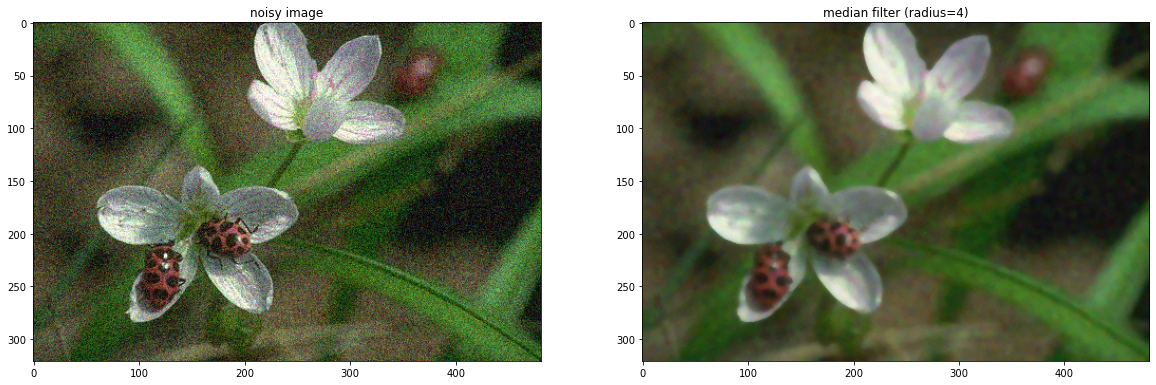

In [365]:
from skimage.filters.rank import median

im_noise=imread('noisy.jpg')
im_med=im_noise.copy()
im_med[:,:,0]= median(im_noise[:,:,0],disk(4))
im_med[:,:,1]= median(im_noise[:,:,1],disk(4))
im_med[:,:,2]= median(im_noise[:,:,2],disk(4))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('noisy image')
plt.imshow(im_noise)
plt.subplot(1,2,2)
plt.title('median filter (radius=4)')
plt.imshow(im_med)
plt.show()

In [396]:
d=30
mask[mask.shape[0]//2-d:mask.shape[0]//2+d+1,mask.shape[1]//2-d:mask.shape[1]//2+dsize+1]=disk(d)

imshow(mask)

#im_m[mask_result==False]=0

ValueError: could not broadcast input array from shape (61,61) into shape (0,0)